# Assignment 6 - Data Science in Finance and Insurance
Submission by: Dennis Goldenberg

In [284]:
import numpy as np;
import pandas as pd;
import plotnine as pn;
from datetime import datetime;
from dateutil.relativedelta import relativedelta
from sklearn.neighbors import NearestNeighbors;
from sklearn.linear_model import LinearRegression;

In [285]:
## From Midterm
data = pd.read_csv("SPX_W_incomplete.csv")

#generate x values
date_grid = []
for i in np.arange(52):
    thisdate = ( datetime.strptime('2023-09-25', '%Y-%m-%d') + relativedelta(weeks = -int(i)) ).strftime('%F')
    date_grid.append(thisdate)
date_grid = np.asarray(date_grid, dtype=np.datetime64)
date_grid = np.flip(date_grid)

#fix date column in dataframe
data_date_Col = [];
for row in data["Date"]:
   thisdate = datetime.strptime(row[0:10], '%Y-%m-%d').strftime('%F')
   data_date_Col.append(thisdate)
data_date_Col = np.asarray(data_date_Col, dtype = np.datetime64)

data['Date'] = data_date_Col

## Part [a]

### Generate Nearest Neighbors (to check for ties)

In [286]:
K = 15;
#target weeks
weeks = np.arange(0, 52)
weekssq = weeks**2

##Find Nearest Neighbors
nn = NearestNeighbors(n_neighbors = K, p = 1).fit(np.asarray(data['WeekNumber']).reshape(-1, 1));
kn = nn.kneighbors(weeks.reshape(-1, 1), K, return_distance= True)

#find max distances - using the 8th nearest neighbor, neighbors in ascending order of distance
distances = kn[0]
maxdistances = np.expand_dims(kn[0][:,14], axis = 1)

#Get scaled distances
scaled_dist = distances/maxdistances

### Generate weeks with Extra Neighbors

In [287]:
week_array = np.asarray(data['WeekNumber']).reshape(-1,1);
extra_array = [];
extra_neighbors_array = [];
for i in range(len(weeks)):
    rn = NearestNeighbors(radius = float(maxdistances[i].item()), p = 1).fit(week_array);
    cn = rn.radius_neighbors(weeks[i].reshape(-1,1), radius = float(maxdistances[i].item()), return_distance= True)
    if len(cn[0][0]) > K:
        extra_array.append(i)
        extra_neighbors_array.append(cn[0][0])
extra_neighbors_array = np.asarray(extra_neighbors_array);

### Report Extra Neighbors

In [288]:
extras = np.asarray([K + 1] * len(extra_array))
extra_data = {"Week Number": extra_array, "Date": date_grid[extra_array], "Number of Neighbors": extras}
extra_df = pd.DataFrame(extra_data)
extra_df

,Week Number,Date,Number of Neighbors
0,14,2023-01-09,16
1,17,2023-01-30,16
2,23,2023-03-13,16
3,24,2023-03-20,16
4,27,2023-04-10,16
5,29,2023-04-24,16
6,32,2023-05-15,16
7,35,2023-06-05,16


## Part [b]

### Create Tri-Cube Function for Weights

In [291]:
#tri-cube function
tricube = lambda distance_vec: np.power(1 - np.power(np.abs(distance_vec), 3), 3)

### Creating Bootstrap Samples from the Incomplete Data

In [292]:
num = 700
def boot_sample(num_samples, input_sample, random_state):
    np.random.seed(random_state)
    list_samples = [];
    for i in range(num_samples):
        sample_i = input_sample.sample(n = len(data), replace = True)
        sample_i = sample_i.set_index(pd.Series([integer for integer in range(len(data))]))
        list_samples.append(sample_i)
    return list_samples

samples = boot_sample(num, data, 100);

### Running LOWESS Regression on EACH POINT from EACH SAMPLE

In [293]:
fits = np.empty(shape = (len(date_grid), num))

weeks = np.arange(0, 52)
weekssq = weeks**2

sample_counter = 0;
for sample in samples:
    week = 0
    means_iter = np.empty(shape = (len(date_grid,)))
    nn = NearestNeighbors(n_neighbors = K, p = 1).fit(np.asarray(sample['WeekNumber']).reshape(-1, 1));
    while week < 52:
        #Find nearest neighbors for current week
        kn = nn.kneighbors(np.asarray([week]).reshape(1, -1), K, return_distance= True)
        distances = kn[0][0]
        maxdistances = distances[K - 1]
        
        #Check for ties of the furthest nearest neighbor using radius neighbors
        cn = nn.radius_neighbors(np.asarray([week]).reshape(1, -1), radius = maxdistances, return_distance = True)
        if len(cn[0][0]) > K:
            distances = cn[0][0]
            X = sample.loc[cn[1][0]]['WeekNumber'].to_numpy();
            y = sample.loc[cn[1][0]]['Close'].to_numpy();
        else:
            X = sample.loc[kn[1][0]]['WeekNumber'].to_numpy();
            y = sample.loc[kn[1][0]]['Close'].to_numpy();
        scaled_dist = np.asarray((distances/maxdistances));
        
        weights = np.asarray(tricube(scaled_dist));

        regressor = LinearRegression().fit(np.asarray([X,X**2]).T,y, sample_weight = weights)
        fits[week, sample_counter] = regressor.predict(np.asarray([week, week**2]).reshape(1, -1))[0]
        week += 1
    sample_counter += 1

### Calculating Means, Standard Deviations, and the Confidence Interval

In [294]:
means = np.mean(fits, axis = 1)
std_errors = np.std(fits, axis = 1)

#using 2.5th and 97.5th percentiles of standard normal
lCI = means - 1.96*std_errors;
uCI = means + 1.96*std_errors;

### Creating DataFrame, Reporting Results

In [295]:
sum_data = pd.DataFrame(np.asarray([weeks, date_grid, means, lCI,uCI]).T, \
                        columns = ["Week Number", "Date", "fit", "CI low", "CI high"])

sum_data['Week Number'] = sum_data['Week Number'].astype(int)
sum_data[['fit', 'CI low', 'CI high']] = sum_data[['fit', 'CI low', 'CI high']].astype(float);
sum_data

,Week Number,Date,fit,CI low,CI high
0,0,2022-10-03,3749.991967,3475.448799,4024.535135
1,1,2022-10-10,3791.961950,3575.284621,4008.639279
2,2,2022-10-17,3829.017035,3660.290937,3997.743134
3,3,2022-10-24,3861.348129,3729.793682,3992.902577
4,4,2022-10-31,3889.152624,3782.861183,3995.444065
5,5,2022-11-07,3912.552127,3819.206100,4005.898154
6,6,2022-11-14,3931.911849,3841.335992,4022.487707
7,7,2022-11-21,3947.663970,3853.061425,4042.266514
8,8,2022-11-28,3958.710075,3860.521859,4056.898290
9,9,2022-12-05,3965.376247,3863.073641,4067.678854


## Part [c]

### Plotting Geom-Smooth, with my regression results superimposed

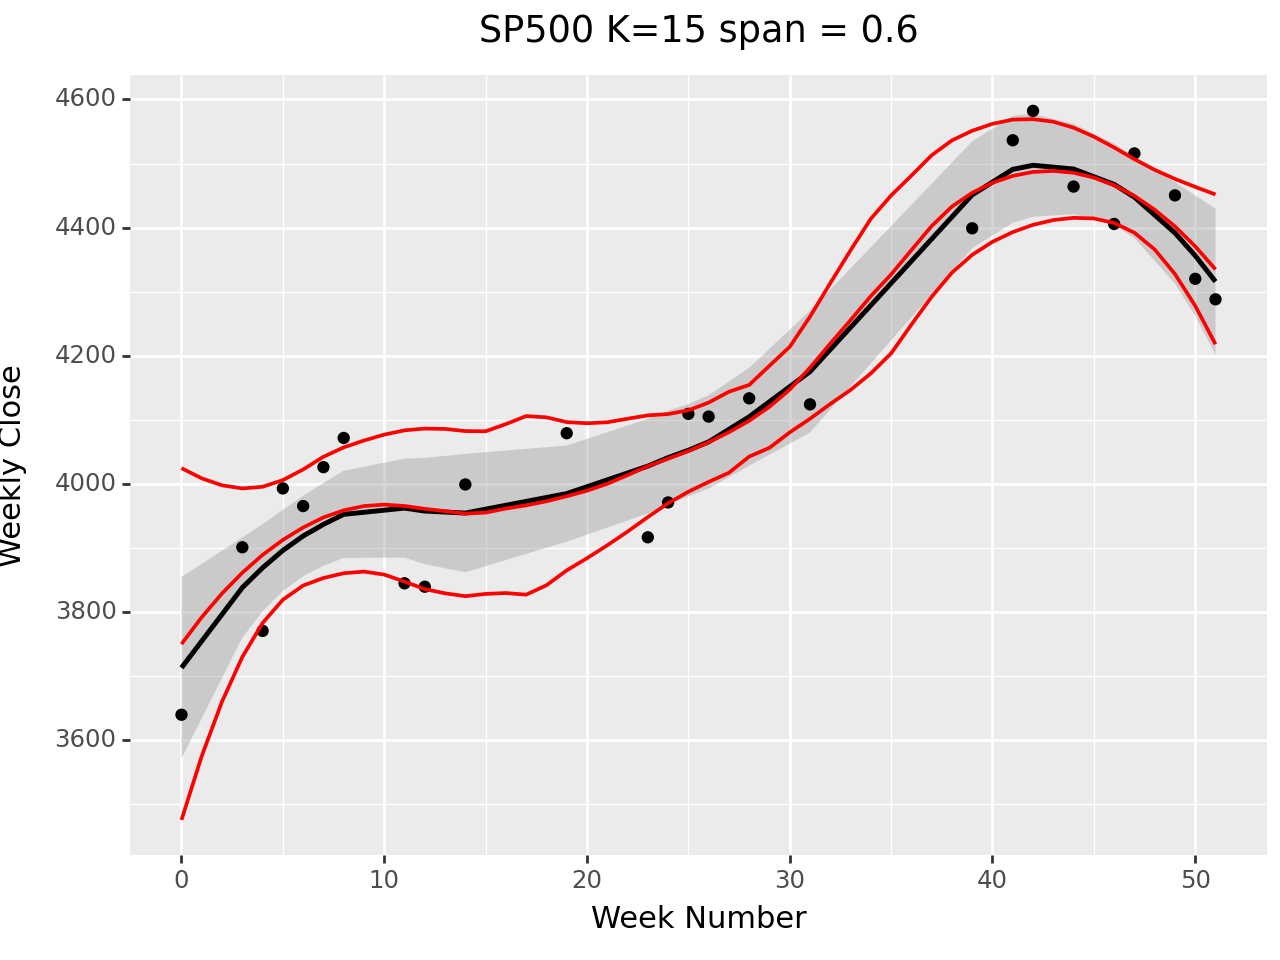

In [296]:
smooth_plot = pn.ggplot() +\
pn.geom_smooth(data, pn.aes(x = "WeekNumber", y = "Close"), method = "loess", span = 0.60, se = True, method_args = {"degree":2,"level":0.95}) +\
pn.geom_point(data, pn.aes(x = "WeekNumber", y = "Close")) +\
pn.geom_line(sum_data, pn.aes(x = "Week Number", y = "fit"), color = 'red', size = .75) +\
pn.geom_line(sum_data, pn.aes(x = "Week Number", y = 'CI low'), color = 'red', size = .75) +\
pn.geom_line(sum_data, pn.aes(x = 'Week Number', y = 'CI high'), color = 'red', size = .75) +\
pn.xlab('Week Number') +\
pn.ylab('Weekly Close') +\
pn.labs(title = 'SP500 K=15 span = 0.6') +\
pn.theme(title = pn.element_text(hjust = 0.5))

print(smooth_plot)